# 📊 Celery Task Creation Benchmark

This notebook benchmarks how **quickly** tasks can be **created** while Celery is **processing other tasks**.

### **Objectives**
✅ Measure **task creation time** under different loads  
✅ Compare **PostgreSQL vs Redis** as Celery backends  
✅ Find the **breaking point** where Celery slows down  
✅ **Visualize performance** with plots  

### **Setup**
- Ensure Celery is running.
- Modify connection settings as needed.


In [7]:
import redis
import psycopg2
import time

# PostgreSQL connection test
PG_HOST = "localhost"
PG_PORT = 5433
PG_USER = "celery_user"
PG_PASSWORD = "celery_pass"
PG_DATABASE = "celery_db"

# Redis Connection Details (Updated)
REDIS_HOST = "192.168.96.3"  # Your Redis server's IP
REDIS_PORT = 6379            # External mapped port
REDIS_DB = 0                 # Default database

def check_postgresql():
    try:
        conn = psycopg2.connect(
            host=PG_HOST,
            port=PG_PORT,
            user=PG_USER,
            password=PG_PASSWORD,
            dbname=PG_DATABASE
        )
        conn.close()
        print("[✅] PostgreSQL is running and accessible.")
        return True
    except Exception as e:
        print(f"[❌] PostgreSQL connection failed: {e}")
        return False

def check_redis():
    try:
        client = redis.StrictRedis(host=REDIS_HOST, port=REDIS_PORT, db=0, decode_responses=True)
        client.ping()
        print("[✅] Redis is running and accessible.")
        return True
    except Exception as e:
        print(f"[❌] Redis connection failed: {e}")
        return False

# Run connection tests
pg_ok = check_postgresql()
redis_ok = check_redis()

if not pg_ok or not redis_ok:
    raise RuntimeError("PostgreSQL or Redis is not accessible. Fix the issue before running benchmarks.")


[✅] PostgreSQL is running and accessible.
[✅] Redis is running and accessible.


[🚀] Benchmarking task creation for 10 tasks on PostgreSQL backend...
[🚀] Benchmarking task creation for 10 tasks on Redis backend...
[🚀] Benchmarking task creation for 100 tasks on PostgreSQL backend...
[🚀] Benchmarking task creation for 100 tasks on Redis backend...
[🚀] Benchmarking task creation for 500 tasks on PostgreSQL backend...
[🚀] Benchmarking task creation for 500 tasks on Redis backend...
[🚀] Benchmarking task creation for 1000 tasks on PostgreSQL backend...
[🚀] Benchmarking task creation for 1000 tasks on Redis backend...


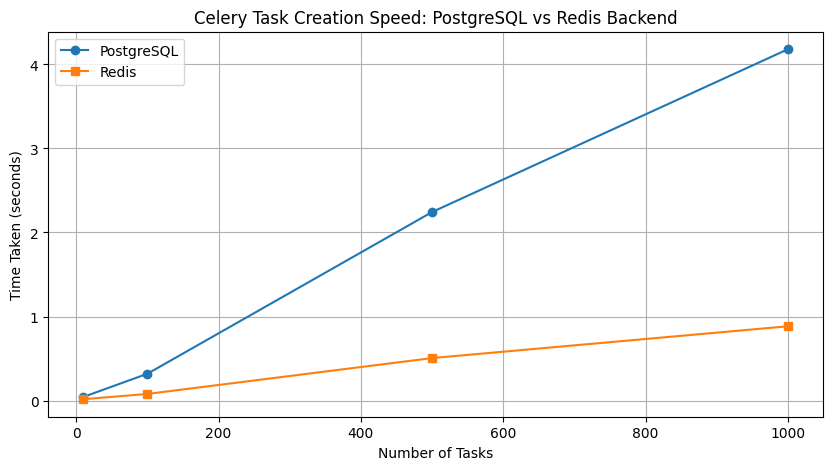

,Task Count,PostgreSQL Backend (s),Redis Backend (s)
0,10,0.042736,0.015612
1,100,0.318952,0.078643
2,500,2.243545,0.505391
3,1000,4.181234,0.883842


In [8]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from celery import Celery

# Celery clients for benchmarking
celery_pg = Celery(
    "tasks",
    broker=f"sqla+postgresql://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DATABASE}",
    backend=f"db+postgresql://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DATABASE}"
)

celery_redis = Celery(
    "tasks",
    broker=f"redis://{REDIS_HOST}:{REDIS_PORT}/0",
    backend=f"redis://{REDIS_HOST}:{REDIS_PORT}/0"
)

# Benchmark function to test task creation speed
def benchmark_task_creation(celery_client, task_count):
    start_time = time.time()
    for _ in range(task_count):
        try:
            celery_client.send_task("tasks.simulate_heavy_task", args=["Benchmark Task"])
        except Exception as e:
            print(f"[❌] Task creation failed: {e}")
    return time.time() - start_time

# Define test cases with different task counts
task_sizes = [10, 100, 500, 1000]
pg_times = []
redis_times = []

for task_count in task_sizes:
    print(f"[🚀] Benchmarking task creation for {task_count} tasks on PostgreSQL backend...")
    pg_time = benchmark_task_creation(celery_pg, task_count)
    pg_times.append(pg_time)

    print(f"[🚀] Benchmarking task creation for {task_count} tasks on Redis backend...")
    redis_time = benchmark_task_creation(celery_redis, task_count)
    redis_times.append(redis_time)

# Store results in a DataFrame
results_df = pd.DataFrame({
    "Task Count": task_sizes,
    "PostgreSQL Backend (s)": pg_times,
    "Redis Backend (s)": redis_times
})

# Visualize results
plt.figure(figsize=(10, 5))
plt.plot(results_df["Task Count"], results_df["PostgreSQL Backend (s)"], marker='o', label="PostgreSQL")
plt.plot(results_df["Task Count"], results_df["Redis Backend (s)"], marker='s', label="Redis")
plt.xlabel("Number of Tasks")
plt.ylabel("Time Taken (seconds)")
plt.title("Celery Task Creation Speed: PostgreSQL vs Redis Backend")
plt.legend()
plt.grid()
plt.show()

# Display DataFrame results
results_df
